# Deep Crossentropy method

In this notebook you will train a multi-layer neural network to solve simple continuous state space games.

In [1]:
pip install gym

  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616827 sha256=a28fefc02f67f69c28ff541389b0b9f5ef0579b3e1aff0fea30528ed493249bb
  Stored in directory: c:\users\tingo\appdata\local\pip\cache\wheels\27\6d\b3\a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
Note: you may need to restart the kernel to use updated packages.


In [100]:
pip install imageio-ffmpeg

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pyglet

  Using cached pyglet-1.5.21-py3-none-any.whl (1.1 MB)



state vector dim = 4
n_actions = 2


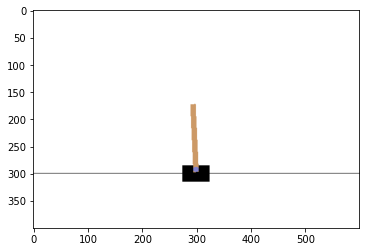

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [2]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [2]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()]* n_actions , range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [2]:
def generate_session(agent, t_max=1000, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()


    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s]* n_actions)[0,:]

        assert probs.shape == (n_actions,), "make sure probabilities are a vector"
        
        # use the probabilities you predicted to pick an action
        if test:
            # on the test use the best (the most likely) actions at test
            # experiment, will it work on the train and vice versa?
            a = np.argmax(probs)
        else:
            # sample proportionally to the probabilities,
            # don't just take the most likely action at train
            a = np.random.choice(range(n_actions), p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [5]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 0.0285834  -0.03990224 -0.04293964 -0.03300667]
 [ 0.02778535  0.15580834 -0.04359978 -0.33892232]
 [ 0.03090152  0.35152268 -0.05037823 -0.6450291 ]
 [ 0.03793197  0.15713765 -0.06327881 -0.36862642]
 [ 0.04107472 -0.03703079 -0.07065134 -0.09654826]]
actions: [1, 1, 0, 0, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy code for this function code from tabular CEM notebook.

The only difference is that now each observation is not a number but a `float32` vector.

Let's see that it differs from tabular `select_elites`. Our neural network now is trained with one object and it takes an input of `(1, n_states)`. So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.

In [3]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states, elite_actions = [], []
    for i in range(len(states_batch)):
        if rewards_batch[i] > reward_threshold:
            elite_states += states_batch[i]
            elite_actions += actions_batch[i]
        
    # Let's see that it differs from tabular `select_elites`.
    # Our neural network now is trained with one object and it takes an input of `(1, n_states)`.
    # So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.
    
    
    
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [4]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    clear_output(True)
    plt.show()
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))

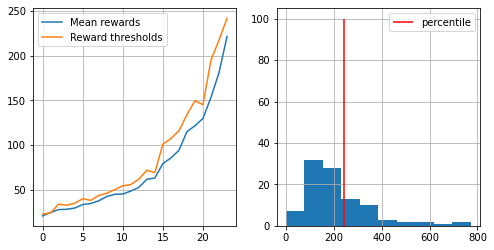

mean reward = 221.380, threshold=241.900
You Win! You may stop training now via KeyboardInterrupt.


In [8]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent.partial_fit(elite_states, elite_actions)

    #<partial_fit agent to predict elite_actions (y) from elite_states (X)>

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Results

In [9]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session(agent, test=True) for _ in range(3)]
env.close()

In [10]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

# Homework (1pt)

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

### Tasks

* __1.1__ (0.5 pt) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ don't be afraid to submit the task even if your agent is below the target score, it will still bring you some points depending on result and errors.
  
  
* __1.2__ (0.5 pt) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/) or multiprocessing
  * Try re-using samples from 3-5 last iterations when computing threshold and training.
  * Experiment with the number of training iterations and learning rate of the neural network (see params).
  
__You must measure your improvement experimentally.__
  
  
  
  
  
  
    
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution. This might help: `conda install swig` + `pip install box2d-py`
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue.
* 20-neuron network is probably not enough, feel free to experiment.
* In MountainCar launch the following snippet *after training* to visualize what your agent learned:

state vector dim = 2
n_actions = 3
Box([-1.2  -0.07], [0.6  0.07], (2,), float32) Discrete(3)


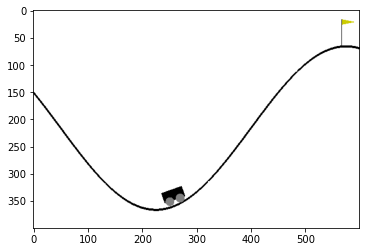

In [18]:
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

print(env.observation_space, env.action_space)

In [19]:
agent = MLPClassifier(
    hidden_layer_sizes=(10, 20, 10),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()]* n_actions , range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 20, 10))

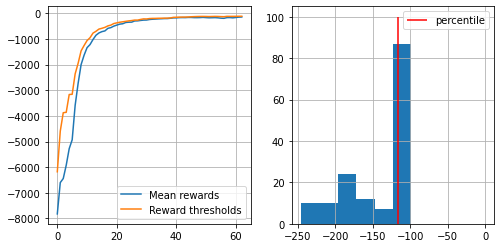

mean reward = -145.227, threshold=-116.000
education completed
time of education: 3364.0  sec


In [20]:
n_sessions = 150
percentile = 70
log = []

import time
start = time.time()

for i in range(150):
    # generate new sessions
    sessions = [generate_session(agent, t_max=10000) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent.partial_fit(elite_states, elite_actions)

    #<partial_fit agent to predict elite_actions (y) from elite_states (X)>

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 0])
    
    if np.mean(rewards_batch) > -150:
        print('education completed')
        break

end = time.time()
print('time of education:', np.round((end - start)), ' sec')

In [21]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("MountainCar-v0"),
                           directory="videos_car", force=True)
sessions = [generate_session(agent, t_max=10000, test=True) for _ in range(3)]
env.close()

# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos_car/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos_car/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

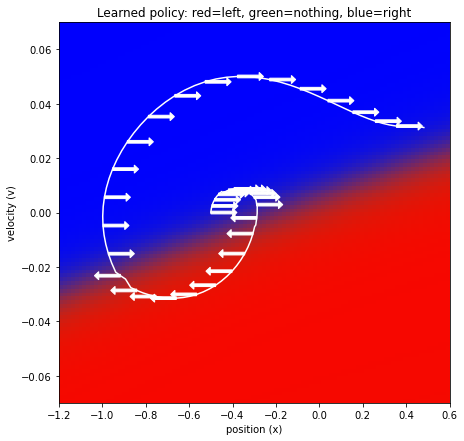

In [22]:
def visualize_mountain_car(agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(agent)

## Accleration

state vector dim = 2
n_actions = 3
Box([-1.2  -0.07], [0.6  0.07], (2,), float32) Discrete(3)


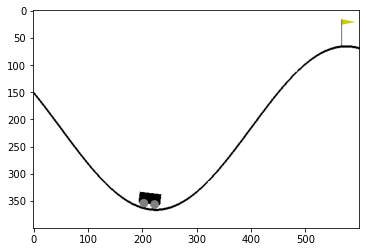

In [15]:
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

print(env.observation_space, env.action_space)   

In [16]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(10, 20, 10),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()]* n_actions , range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 20, 10))

#### Добавим parallel (n_jobs=4)

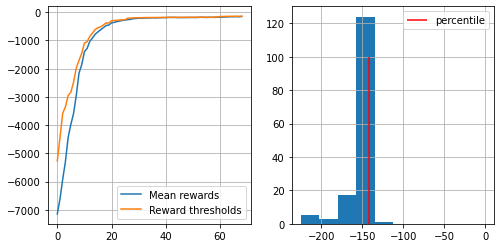

mean reward = -149.973, threshold=-142.000
education completed
time of education: 1302.0  sec


In [17]:
from joblib import Parallel, delayed

n_sessions = 150
percentile = 70

log = []

cache_elites_states = []
cache_elites_actions = []
m_prev = 0

import time
start = time.time()

for i in range(150):

    sessions = Parallel(n_jobs=4)(delayed(generate_session)(agent, t_max=10000) for _ in range(n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile) 
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 0])
    
    if np.mean(rewards_batch) > -150:
        print('education completed')
        break

end = time.time()
print('time of education:', np.round((end - start)), ' sec')

#### Получили двукратное ускорение по сравнению с начальным обучением

### Bonus tasks

* __1.3 bonus__ (0.5 pt) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve; yet more than -50 is already performing good), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * Note that discrete and continuous environments may have slightly different rules aside from action spaces.

In [10]:
env_c = gym.make("MountainCarContinuous-v0").env

env_c.reset()
state_dim = env_c.observation_space.shape[0]
print(env_c.observation_space, env_c.action_space)
env_c.close()

Box([-1.2  -0.07], [0.6  0.07], (2,), float32) Box([-1.], [1.], (1,), float32)


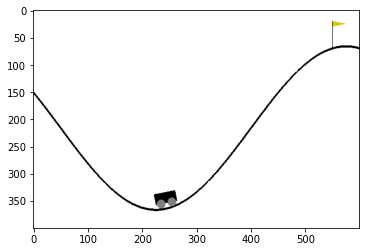

In [39]:
plt.imshow(env_c.render("rgb_array"))

In [11]:
from sklearn.neural_network import MLPRegressor

agent_c = MLPRegressor(
    hidden_layer_sizes=(10, 20, 10),
    activation='identity',
)

agent_c.partial_fit([env_c.reset()] , np.random.randint(low=-100, high=100, size=1))

MLPRegressor(activation='identity', hidden_layer_sizes=(10, 20, 10))

In [8]:
def generate_session_continious(agent, t_max=10000, sigma=2, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env_c.reset()


    for t in range(t_max):
        
        # predict next step
        pred = agent.predict([s])
        
        if test:
            a = pred
            
        else:
            #choose from normal distribution with mean = predictions
            a = pred + sigma * np.random.randn(1)

        new_s, r, done, info = env_c.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

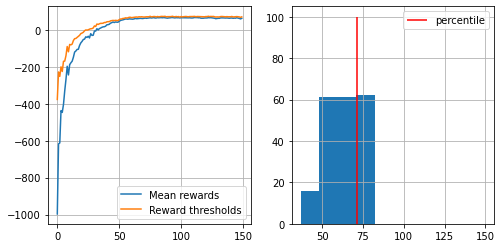

mean reward = 63.187, threshold=71.075
time of education: 729.0  sec


In [12]:
from joblib import Parallel, delayed

n_sessions = 200
percentile = 70
log = []

import time
start = time.time()

for i in range(150):

    sessions = Parallel(n_jobs=4)(delayed(generate_session_continious)(agent_c, t_max=15000, sigma=1) for _ in range(n_sessions))

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent_c.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), 150])
    
    if np.mean(rewards_batch) > 90:
        print('education completed')
        break

end = time.time()
print('time of education:', np.round((end - start)), ' sec')

In [14]:
# record sessions
import gym.wrappers
env_c = gym.wrappers.Monitor(gym.make("MountainCarContinuous-v0"),
                           directory="videos_car_c", force=True)
sessions = [generate_session_continious(agent_c, t_max=10000, test=True) for _ in range(3)]
env_c.close()

# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos_car_c/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos_car_c/"+video_names[-2]))  # this may or may not be _last_ video. Try other indices